# Imports

In [ ]:
# descargar librerias necesarias
!pip install pandas
!pip install xlrd
!pip install pyspark

In [121]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import dayofweek, dayofyear, dayofmonth, weekofyear, month, year

from pyspark.sql import functions # usaremos -> mean, stddev, max, min

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# FUNCIONES FINALES PARA EL ANÁLISIS

Comentario: Se podrían explicar más en detalle las funciones en un script aparte y así el análisis / resultados queda más limpio.

In [137]:

def preprocess_dates(df):
        
    df_new = df.withColumn("dayofweek", dayofweek(df.unplug_hourTime.getItem("$date")))\
            .withColumn("dayofyear", dayofyear(df.unplug_hourTime.getItem("$date")))\
            .withColumn("weekofyear", weekofyear(df.unplug_hourTime.getItem("$date")))\
            .withColumn("year", year(df.unplug_hourTime.getItem("$date")))\
            .drop('unplug_hourTime')
    return df_new


def preprocess_ids(df):
    
    data_geo  = "datos/bases_bicimad.csv"
    
    df_geo  = spark.read.csv(data_geo, header=True)\
                            .select("Número", "Barrio")\
                                .withColumnRenamed("Número", "idplug_station")\
                                .withColumnRenamed("Barrio", "id_llegadas")
    df_geo2 = df_geo.withColumnRenamed("idplug_station", "idunplug_station")\
                                .withColumnRenamed("id_llegadas", "id_salidas")

    df_new = df.join(df_geo, on="idplug_station").join(df_geo2, on="idunplug_station")\
                            .drop("idplug_station", "idunplug_station", "idplug_base", "idunplug_base")
    
    return df_new



def get_random_barrio(df):
    # Serán pocos valores (el nº de barrios) por lo que aunque parezca que hay mucho paso 
    # a pandas y a listas, la operación no es costosa. De todas formas lo suyo es que seleccionemos nosotros
    # uno manualmente
    return np.random.choice(df.select("id_salidas").distinct().toPandas()["id_salidas"].to_list())

def get_years(df):
    # Guardar una lista con todos los años disponibles del DataFrame -> no serán más de 2 / 3 valores 
    # por lo que aunque parezca que hay mucho paso a pandas y a listas, la operación no es costosa
    years = df.select("year").distinct().toPandas()["year"].to_list()
    years = list(map(str, years)) # pasarlo a tipo string
    return years



def plot_analisys_by_day(df, barrio=None, total=False, years=None): # total == True -> estudio uniendo todos los barrios
    
     # Según queramos o no un estudio total modificamos el DataFrame
    if not total:
        if barrio == None:
            barrio = get_random_barrio(df)

        df_barrio = df.filter(df.id_salidas == barrio)
    else:
        df_barrio = df
    
    years = years if years != None else get_years(df)
    
    df_plot = None
    
    # Agrupamos por años los datos 
    for year in years:
        df_year = df_barrio.filter(df.year == year)\
                            .groupBy("dayofweek").count()\
                                .withColumnRenamed("count", year)
        if df_plot == None:
            df_plot = df_year
        else:
            df_plot = df_plot.join(df_year, on="dayofweek")
    
    # Ordenar temporalmente (dayofweek) y luego hacemos un plot de todos los años
    ss = f" del barrio:\n{barrio}" if not total else ""
    df_plot.orderBy("dayofweek").toPandas().plot.bar(
            x = "dayofweek", 
            y = years,
            title = f"Visualización de los movimientos\n por días de la semana{ss}",
            ylabel="nº de movimientos totales",
            xlabel=""
    ).set_xticklabels(["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"])
    


def plot_analisys_by_year(df):
    
    years = get_years(df)
    
    df_plot = None
    
    # hacer una columna para cada año del conteo de la columna que queramos medir
    for year in years:
        df_year = df.filter(df.year == year)\
                            .groupBy("weekofyear").count()\
                                .withColumnRenamed("count", year)
        if df_plot == None:
            df_plot = df_year
        else:
            df_plot = df_plot.join(df_year, on="weekofyear")
    
    # ordenar temporalmente (weekofyear) y luego hacer un plot de todos los años
    df_plot.orderBy("weekofyear").toPandas().plot(
            x = "weekofyear", 
            y = years,
            title = "Visualización global\nde los movimientos de las bicis",
            xlabel="semana",
            ylabel="nº de movimientos"
    )


def plot_stats(df):
    
    years = get_years(df)
    
    # nº de filas y columnas del plot final
    c = min(2, len(years))
    f = 1 + max(0, (len(years)-1)) // c
    
    # crear plot
    fig = plt.figure(figsize=(15,5*f))
    
    for i, year in enumerate(years):
        
        df2 = df.filter(df.year == year).groupBy('id_salidas', 'dayofweek').count().orderBy('id_salidas')

        # Añadir la desviación típica y la media de cada una de las estaciones
        df_stats = df2.groupBy("id_salidas").agg(
                functions.mean("count").alias("mean"), 
                functions.stddev("count").alias('std'),
                functions.min("count").alias('min'),
                functions.max("count").alias('max'),
        ).toPandas()

        # Cambiar la columna std por la relativa, ya que es la que nos interesa. 
        # Luego multiplicamos por el valor medio máximo para que se aprecien los valores en la 
        # gráfica (los valores reales serán proporcionales a los resultados)
        df_stats["std"] = df_stats["std"] / df_stats["mean"] * df_stats["mean"].max()
        
        # Columna con las diferencias (relativas) máximo - mínimo
        df_stats["dif"] = (df_stats["max"] - df_stats["min"]) / df_stats["mean"]
        
        maximo_std = df_stats[df_stats["std"] == df_stats["std"].max()]
        maximo_dif = df_stats[df_stats["dif"] == df_stats["dif"].max()]

        # Graficar los resultados. Tendremos:
        #  - BarPlot de los valores medios (en gris transparente para después aprecias las std)
        #  - LinePlot de las std (relativa) en rojo
        #  - ScatterPlot del valor máximo de : relative std -> para después analizarlo
        n = df_stats.shape[0]
        x = range(n)
        

        ax = fig.add_subplot(f, c, 1+i)

        ax.plot(x, df_stats["std"].values, "m-", label="std")
        ax.bar(x, df_stats["mean"].values, color="grey", alpha=0.8, label="mean")
        ax.bar(maximo_std.index[0], maximo_std["mean"].values[0], 
                   color="m", label="max std: " + str(maximo_std["id_salidas"].values[0]))
        ax.bar(maximo_dif.index[0], maximo_dif["mean"].values[0], 
                    color="red", label="max dif: " + str(maximo_dif["id_salidas"].values[0]))
        ax.legend()
        ax.set_xlabel("Barrios")
        ax.set_ylabel("Usos de las bicis")
        ax.set_xticks([])
        ax.set_title(f"Datos estadísticos sobre los barrios\n--{year}--")
    
    plt.show()


# ANÁLISIS FINAL

### Cargar los datos

In [4]:
spark = SparkSession.builder.getOrCreate()

In [6]:
df = spark.read.json("datos/sample_10e4.json")

### Preprocesamiento de datos

In [7]:
df = preprocess_dates(df)
df = preprocess_ids(df)

### Visualizar movimientos globales por años

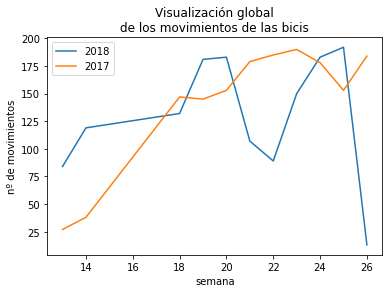

In [8]:
plot_analisys_by_year(df)

### Visualización de los movimientos semanales totales

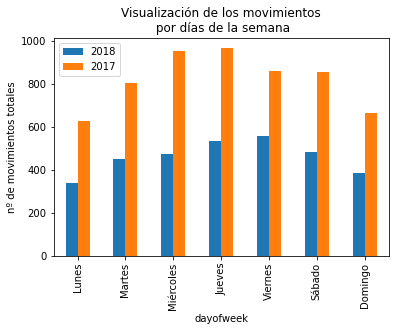

In [9]:
plot_analisys_by_day(df, total=True)

Parece que encontramos gran uniformidad en los datos, hay que tener en cuenta que este es un estudio global, por lo que nos está diciendo que durante todos los días de la semana se usan relativamente igual todas las bicis por Madrid.

Ahora bien, queremos observar por que zonas se mueven más unos días y por qué otras zonas se mueven otros días.

### Visualización de los movimientos semanales de un barrio concreto 

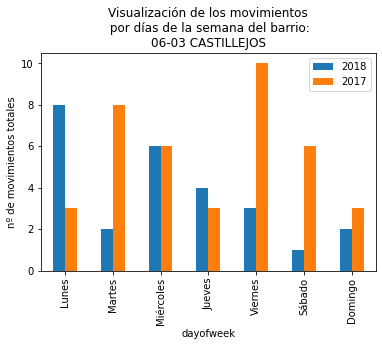

In [10]:
barrio = "06-03 CASTILLEJOS"
plot_analisys_by_day(df, barrio)

Se observa gran movimiento en general los viernes en 2017 y poco los domingos en ambos años. También observamos grandes diferencias entre ambos años el lunes.

Esta elección a sido aleatoria. Vamos ahora a buscar estadísticamente barrios interesantes de los que buscar resultados.

### Agrupar toda la información anterior por barrios, así podemos realizar unos análisis globales

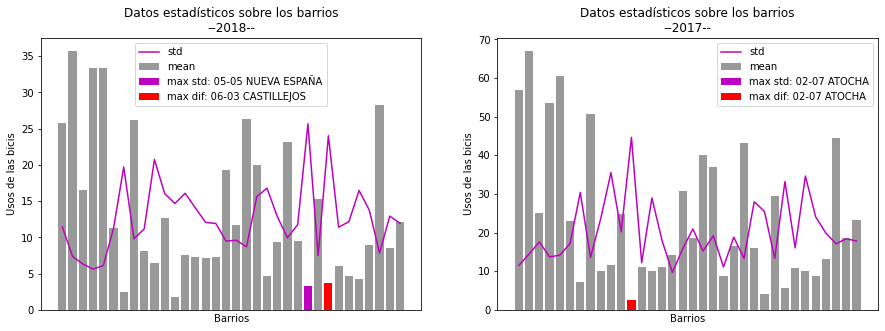

In [138]:
plot_stats(df)

### Veamos los datos diarios de los barrios que nos han dado mayores desviaciones típicas y diferencias

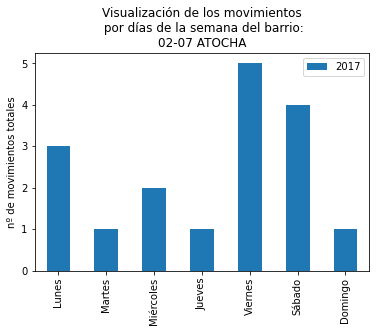

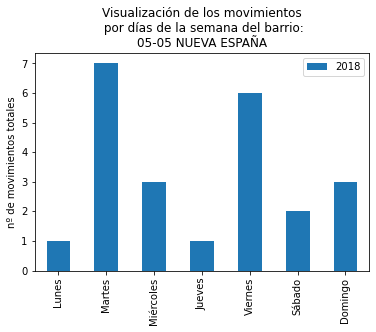

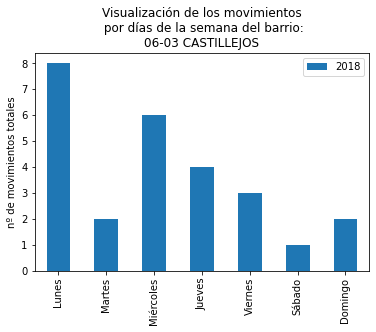

In [139]:
barrio_2017 = "02-07 ATOCHA"
barrio_2018_maxSTD = "05-05 NUEVA ESPAÑA"
barrio_2018_maxDIF = "06-03 CASTILLEJOS"

plot_analisys_by_day(df, barrio_2017, years=["2017"])
plot_analisys_by_day(df, barrio_2018_maxSTD, years=["2018"])
plot_analisys_by_day(df, barrio_2018_maxDIF, years=["2018"])

 - Año 2017:
 
  - **02-07 ATOCHA**: se observa una diferencia considerable en los días viernes y sabado, es decir, durante la llegada del fin de semana es una zona bastante transitada a diferencia de los demás días de la semana.

 - Año 2018:
 
  - **05-05 NUEVA ESPAÑA**: no nos proporciona datos concluyentes ya que tiene picos alternados entre el martes y el viernes.
 
  - **06-03 CASTILLEJOS**: Se observa un claro descenso a lo largo del transcurso de la semana. Dejando los fines de semana casi inactivos en comparación con los días laborales.


### Ahora pordemos separar esto en vez de con todos los días de la semana separando en dos grupos:

 - Entre semana: Lunes, ..., Viernes
 - Fin de semana: Viernes, Sábado, Domingo

### y así conseguir un estudio final que nos diga en que zonas hay mucho cambio en la demanda entre laborales y fines de semana. 

En proceso... me voy a comer ;)